<a href="https://colab.research.google.com/github/archipelcitoyen/TAS_2026/blob/main/TAS_INSEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ANALYSE DES CARREAUX INSEE 2019 POUR LE CIBLAGE DU PORTE-À-PORTE - MUNICIPALES TOULOUSE 2026 - ARCHIPEL CITOYEN

In [18]:
import geopandas as gpd
import os
import folium
from folium import FeatureGroup, GeoJson
import branca.colormap as cm
from insee import *

In [19]:
# Configuration
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [20]:
filename_toulouse = os.path.join(DATA_DIR, "carreaux_toulouse.gpkg")
if os.path.exists(filename_toulouse):
    print(f"✅ Le fichier {filename_toulouse} existe déjà, on le charge.")
else:
    print("🔄 Le fichier n'existe pas, exécution de la fonction.")
    telecharger_donnees_insee(DATA_DIR)
    carreaux_gdf = charger_donnees_insee_local(os.path.join(DATA_DIR, "Filosofi2019_carreaux_200m_gpkg","carreaux_200m_met.gpkg"))
    #carreaux_toulouse = decouper_carreaux_toulouse(carreaux_gdf, toulouse_gdf)
    carreaux_toulouse = carreaux_gdf[carreaux_gdf['lcog_geo'] == '31555']
    carreaux_toulouse.to_file(filename_toulouse, driver="GPKG")


✅ Le fichier data/carreaux_toulouse.gpkg existe déjà, on le charge.


Calcul de l'indicateur d'invisibilisation...


<Axes: >

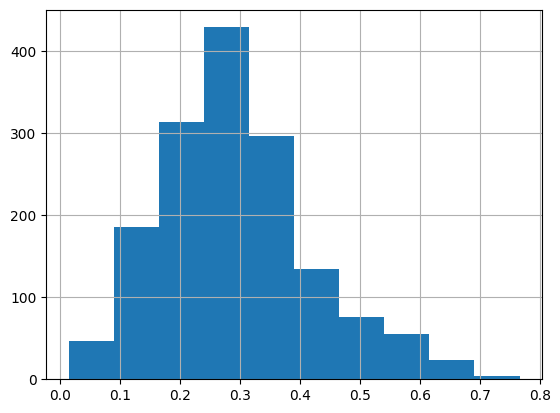

In [21]:
gdf = gpd.read_file(filename_toulouse)
print("Calcul de l'indicateur d'invisibilisation...")
gdf = calculer_indicateurs(gdf)
gdf = normaliser_indicateurs(gdf)
gdf = calculer_indicateur_composite(gdf)
gdf = filtrer_carreaux(gdf)
#gdf.to_file(chemin_fichier, driver="GPKG")
gdf['indicateur_invisibilisation'].hist()


In [26]:
# Filtrer les carreaux avec un indicateur de précarité supérieur ou égal à `seuil`
seuil = 0.5
nb_de_point_TAS = 15
gdf_invisibilise = gdf[gdf['indicateur_invisibilisation'] >= seuil].copy()
gdf_sample = gdf_invisibilise.sample(n=nb_de_point_TAS, random_state=42).copy()
gdf_sample['random_point'] = gdf_sample.geometry.apply(random_point_in_polygon)
gdf_sample['random_point'] = gdf_sample['random_point'].to_crs(epsg=4326)

In [27]:
# Vérifier et définir la projection si nécessaire
if gdf.crs is None:
    gdf.set_crs(epsg=2154, inplace=True)  # Lambert-93, projection courante en France

m = folium.Map(location=[43.6045, 1.4442], zoom_start=12, tiles=None)
folium.TileLayer(
    tiles='CartoDB positron',
    name='Fond de carte',
    control=False
).add_to(m)

colormap = cm.linear.YlOrRd_09.scale(0, 1)
colormap.caption = 'Indicateur normalisé'
colormap.add_to(m)

# Liste des variables à visualiser
variables = {
    "Ménages pauvres": 'norm_pct_men_pauvres',
    "Familles monoparentales": 'norm_pct_men_monoparentales',
    "Individus entre 18 et 24 ans": 'norm_pct_ind_18_24',
    "Logements sociaux": 'norm_pct_log_soc',
    "Ménages en logements collectifs": 'norm_pct_men_coll',
    "Taux de locataires": 'norm_pct_locataires',
    "➡️ Indicateur d'invisibilisation": "indicateur_invisibilisation"
}

for nom_couche, colonne in variables.items():
    fg = folium.FeatureGroup(name=nom_couche, show=(colonne == "indicateur_invisibilisation"))
    folium.GeoJson(
        gdf,
        style_function=lambda feature, col=colonne: {
            'fillColor': colormap(feature['properties'][col]) if feature['properties'][col] is not None else '#gray',
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7
        },
        tooltip=folium.GeoJsonTooltip(fields=[colonne], aliases=[nom_couche])
    ).add_to(fg)
    fg.add_to(m)

# Couche des carreaux sélectionnés
fg_precaires = FeatureGroup(name="✅ Carreaux ciblés", show=False)
GeoJson(
    gdf_invisibilise,
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=['indicateur_invisibilisation'], aliases=["Indicateur d'invibilisation"])
).add_to(fg_precaires)
fg_precaires.add_to(m)

# Couche des points aléatoires
fg_points = FeatureGroup(name="🎯 Points tirés au sort", show=True)
for idx, row in gdf_sample.iterrows():
    lon, lat = row['random_point'].x, row['random_point'].y
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='orange', icon='bullseye', prefix='fa'),
        popup=f"Point tiré au sort"
    ).add_to(fg_points)
fg_points.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("carte_invisibilisation_toulouse.html")

In [28]:
print(gdf_sample['random_point'] )

938     POINT (1.41484 43.59465)
230     POINT (1.46627 43.56526)
149     POINT (1.50106 43.56392)
1169    POINT (1.46956 43.60847)
624      POINT (1.39885 43.5811)
630     POINT (1.41745 43.58263)
409     POINT (1.47154 43.57648)
506     POINT (1.43296 43.57725)
1437     POINT (1.44309 43.6188)
236     POINT (1.50503 43.56923)
977     POINT (1.39535 43.59526)
979     POINT (1.40008 43.59515)
83      POINT (1.50076 43.55834)
981     POINT (1.40488 43.59544)
284     POINT (1.40495 43.56398)
Name: random_point, dtype: geometry
